In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import json
import builtins

In [ ]:
from pyspark.sql import SparkSession
from Functions.data_extraction import movie
from Functions.data_cleaning import extract_data, extract_name,get_director,separate_data,get_cast_names,get_crew_names
from Functions.KPIs_Analysis import rank_movies
from Functions.Visualization import plot_revenue_vs_budget,plot_roi_by_genre,plot_franchise_vs_standalone_revenue,plot_yearly_trends,plot_popularity_vs_rating
from pyspark.sql.functions import col, lit, round, size, coalesce
from pyspark.sql.types import DoubleType

In [3]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("TMDB Movie Analysis") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("✓ PySpark initialized successfully!")
print(f"   Spark Version: {spark.version}")

✓ PySpark initialized successfully!
   Spark Version: 3.5.0


DATA EXTRACTION

In [4]:
#Extracting perferred movie data from the Api
key = os.getenv("key")

movies = []

movie_ids = [0,299534, 19995, 140607, 299536, 597, 135397, 420818,
             24428, 168259, 99861, 284054, 12445, 181808, 330457,
               351286, 109445, 321612, 260513
]

for movie_id in movie_ids:
    movies.append(movie(movie_id,key))

#print(movies)

Movie ID 0 not found (404). Skipping.


In [5]:
movies = list(builtins.filter(None, movies))

In [ ]:
# try:
#     with open('tmbd_movies.json', 'w', encoding='utf-8') as f:
#         json.dump(movies, f, indent=4, ensure_ascii=False)
#     print("JSON file saved successfully.")

# except FileNotFoundError as e:
#     print(f"File path error: {e}")

# except TypeError as e:
#     print(f"Serialization error (possibly non-JSON-serializable data): {e}")

# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

DATA TRANSFORMATION

In [6]:
# Read with multiLine and let Spark infer schema
df = spark.read \
    .option("multiLine", "true") \
    .option("mode", "PERMISSIVE") \
    .option("columnNameOfCorruptRecord", "_corrupt_record") \
    .json('tmdb_movies.json')

In [7]:
# Apply extract_data function to get genre names
df = df.withColumn("genres", extract_data(col("genres")))

# Apply extract_name function to get collection names
# Need to pass 'name' as a literal column since the UDF expects column parameters
df = df.withColumn("belongs_to_collection", extract_name(col("belongs_to_collection"), lit("name")))

# Apply extract_data function to get production countries names
df = df.withColumn("production_countries", extract_data(col("production_countries")))

# Apply extract_data function to get production companies names
df = df.withColumn("production_companies", extract_data(col("production_companies")))

# Apply extract_data function to get spoken_languages
df = df.withColumn("spoken_languages", extract_data(col("spoken_languages")))

In [8]:
df = df.withColumn("cast", get_cast_names(col("credits")))
df = df.withColumn("crew", get_crew_names(col("credits")))

In [9]:
df = df.withColumn("director", get_director(col("credits")))

In [10]:
df = (
    df
    .withColumn("cast_size", coalesce(size(col("credits.cast")), lit(0)))
    .withColumn("crew_size", coalesce(size(col("credits.crew")), lit(0)))
)


In [11]:
cols_to_drop = ["adult", "imdb_id", "original_title", "video", "homepage"]
df = df.drop(*cols_to_drop)


In [12]:
columns_to_separate = ['genres', 'spoken_languages', 'production_countries', 'production_companies','cast','crew']
for column in columns_to_separate:
    df = separate_data(df, column)


In [13]:
# Convert budget & revenue to millions and round to 2 decimals
df = df.withColumn("budget_musd", round(col("budget") / 1_000_000, 2)) \
       .withColumn("revenue_musd", round(col("revenue") / 1_000_000, 2))


In [14]:
# Drop the 'status' column
df = df.drop("status")


In [15]:
df = df.select('id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 
         'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 
         'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime',
           'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size')

KPI's

In [16]:
# Ensure numeric (cast to double)
df = (
    df
    .withColumn("budget_musd", col("budget_musd").cast(DoubleType()))
    .withColumn("revenue_musd", col("revenue_musd").cast(DoubleType()))
)

# Profit
df = df.withColumn(
    "profit",
    col("revenue_musd") - col("budget_musd")
)

# ROI
df = df.withColumn(
    "roi",
    (col("revenue_musd") / col("budget_musd")) * 100
)

In [17]:
# Top 5 movies by revenue
highest_revenue = rank_movies(df, column='revenue_musd', n=5)

for i, row in enumerate(highest_revenue.collect(), 1):
    print(f"{i}. {row['title']} - ${row['revenue_musd']}M")

1. Avatar - $2923.71M
2. Avengers: Endgame - $2799.44M
3. Titanic - $2264.16M
4. Star Wars: The Force Awakens - $2068.22M
5. Avengers: Infinity War - $2052.42M


In [18]:
# Highest Budget using rank_movies 
highest_budget = rank_movies(df, column='budget_musd', n=1) 
for row in highest_budget.collect(): 
    print(f"The highest budget: ${row['budget_musd']}M - {row['title']}")


The highest budget: $356.0M - Avengers: Endgame


In [19]:
#Highest profit
highest_profit = rank_movies(df, column='profit', n=1) 
for row in highest_profit.collect(): 
    print(f'The highest profit: ${row["profit"]}M - {row["title"]}')

The highest profit: $2686.71M - Avatar


In [20]:
#Lowest profit
lowest_profit = rank_movies(df, column='profit', ascending=True, n=1) 
for row in lowest_profit.collect(): 
    print(f'The lowest profit: ${row["profit"]}M - {row["title"]}')

The lowest profit: $1032.7M - Star Wars: The Last Jedi


In [21]:
# Highest ROI using rank_movies (only movies with Budget >= 10M)
highest_roi = rank_movies(df, column='roi', n=1, min_budget=10)
for row in highest_roi.collect():
    print(f'The highest Return On Investment: {row["roi"]:.2f}M - {row["title"]}')

The highest Return On Investment: 1233.63M - Avatar


In [22]:
# Lowest ROI using rank_movies (only movies with Budget >= 10M)
lowest_roi = rank_movies(df, column='roi', ascending=True, n=1, min_budget=10)
for row in lowest_roi.collect():
    print(f'The lowest Return On Investment: {row["roi"]:.2f}M - {row["title"]}')

The lowest Return On Investment: 444.23M - Star Wars: The Last Jedi


In [23]:
# Most Voted Movies using rank_movies
most_voted = rank_movies(df, column='vote_count', n=1)

for row in most_voted.collect():
    print(f'The most voted movie: {row["title"]}')

The most voted movie: The Avengers


In [24]:
# Highest Rated Movies (only movies with ≥ 10 votes)
highest_rate = rank_movies(df, column='vote_average', n=1, min_votes=10)
for row in highest_rate.collect():
    print(f'The most rated movie: {row["vote_average"]} - {row["title"]}')

The most rated movie: 8.238 - Avengers: Endgame


In [25]:
# Lowest Rated Movies (only movies with ≥ 10 votes) using rank_movies
lowest_rate = rank_movies(df, column='vote_average', ascending=True, n=1, min_votes=10)
for row in lowest_rate.collect():
    print(f'The lowest rated movie: {row["vote_average"]} - {row["title"]}')

The lowest rated movie: 6.536 - Jurassic World: Fallen Kingdom


In [26]:
# Most Popular Movies using rank_movies
most_popular = rank_movies(df, column='popularity', n=1)
for row in most_popular.collect():
    print(f'The most popular movie: {row["title"]}')

The most popular movie: Avatar


In [27]:
filtered_for_Bruce = (
    df.filter(
        (col("cast").rlike("(?i)Bruce Willis")) &
        (col("genres").rlike("(?i)Science Fiction")) &
        (col("genres").rlike("(?i)Action"))
    )
    .orderBy(col("vote_average").desc())
)

# Collect results
results = filtered_for_Bruce.collect()

if results:
    movie_name = results[0]["title"]
    print(f"The best-rated Science Fiction Action movies starring Bruce Willis: {movie_name}")
else:
    print("No movies found matching the criteria.")


No movies found matching the criteria.


In [28]:
filtered_movies = (
    df.filter(
        (col("cast").rlike("(?i)Uma Thurman")) &
        (col("director").rlike("(?i)Quentin Tarantino"))
    )
    .orderBy(col("runtime").asc())
)

# Collect results
results = filtered_movies.collect()

if results:
    movie_name = results[0]["title"]
    print(f"The movies starring Uma Thurman, directed by Quentin Tarantino: {movie_name}")
else:
    print("No movies found matching the criteria.")


No movies found matching the criteria.


In [29]:
# Separate franchise and standalone movies
franchise_movies = df.filter(col("belongs_to_collection").isNotNull()) 
standalone_movies = df.filter(col("belongs_to_collection").isNull())

In [30]:
# Mean calculations using selectExpr
mean_revenue = franchise_movies.selectExpr("avg(revenue_musd)").collect()[0][0]
mean_budget = franchise_movies.selectExpr("avg(budget_musd)").collect()[0][0]
mean_popularity = franchise_movies.selectExpr("avg(popularity)").collect()[0][0]
mean_rating = franchise_movies.selectExpr("avg(vote_average)").collect()[0][0]

# Median ROI using approxQuantile (still needed, Spark has no direct median)
median_roi = franchise_movies.approxQuantile("roi", [0.5], 0.01)[0]

# Put results into a dictionary
franchise_stats = {
    "Mean Revenue": mean_revenue,
    "Median ROI": median_roi,
    "Mean Budget": mean_budget,
    "Mean Popularity": mean_popularity,
    "Mean Rating": mean_rating
}


In [31]:
from pyspark.sql import functions as F
franchise_summary = (
    franchise_movies.groupBy("belongs_to_collection")
    .agg(
        F.count("id").alias("total_movies"),
        F.sum("budget_musd").alias("total_budget"),
        F.avg("budget_musd").alias("mean_budget"),
        F.sum("revenue_musd").alias("total_revenue"),
        F.avg("revenue_musd").alias("mean_revenue"),
        F.avg("vote_average").alias("mean_rating")
    )
    .orderBy(F.col("total_revenue").desc())
)



In [32]:
# Filter out movies without director info
directors_df = df.filter(df["director"].isNotNull())

# Group and aggregate
director_summary = (
    directors_df.groupBy("director")
    .agg(
        F.count("id").alias("total_movies"),
        F.sum("revenue_musd").alias("total_revenue"),
        F.avg("vote_average").alias("mean_rating")
    )
    .orderBy(F.col("total_revenue").desc())
)



DATA VISUALITION

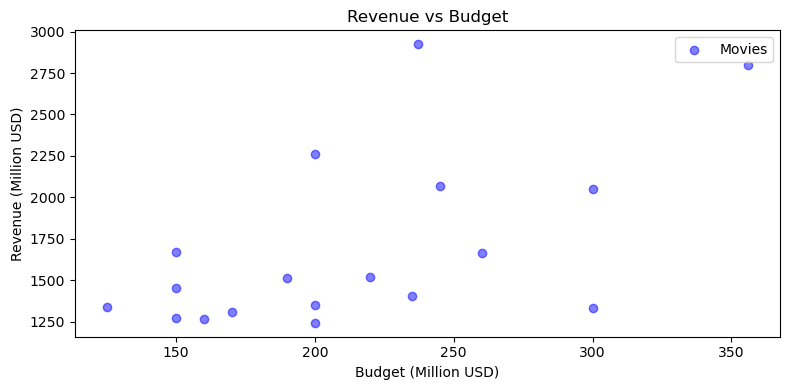

In [33]:
# Convert Spark DataFrame to Pandas
plot_revenue_vs_budget(df)


/opt/spark/Functions/Visualization.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/opt/spark/Functions/Visualization.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


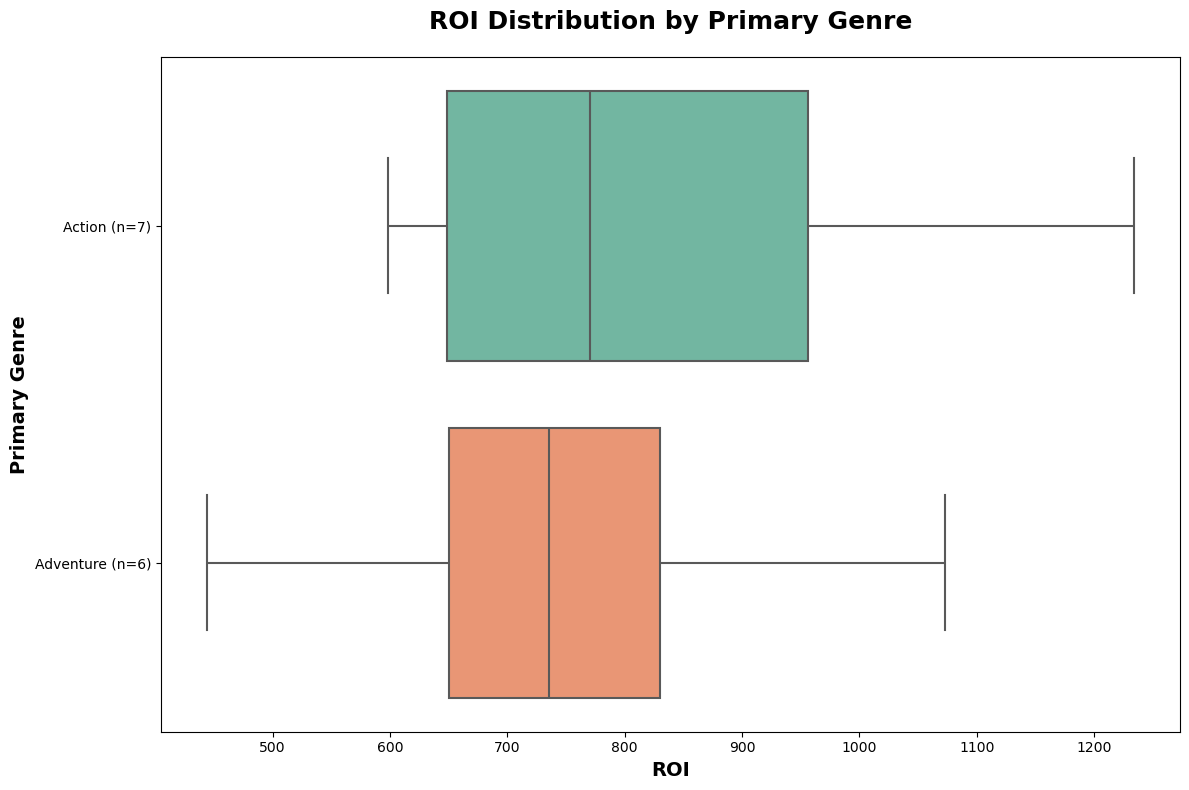

In [34]:
plot_roi_by_genre(df)

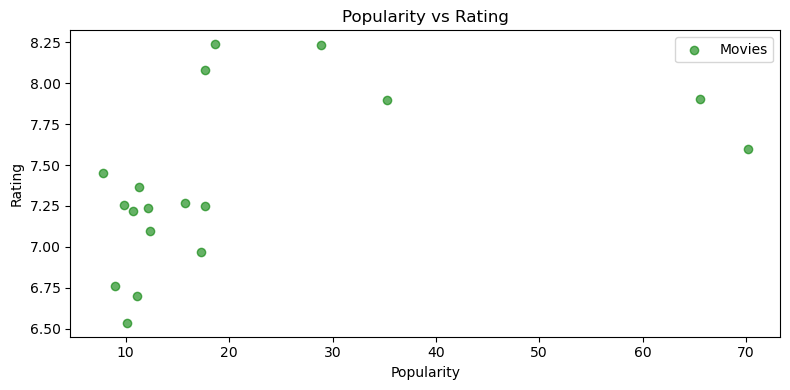

In [35]:
plot_popularity_vs_rating(df)

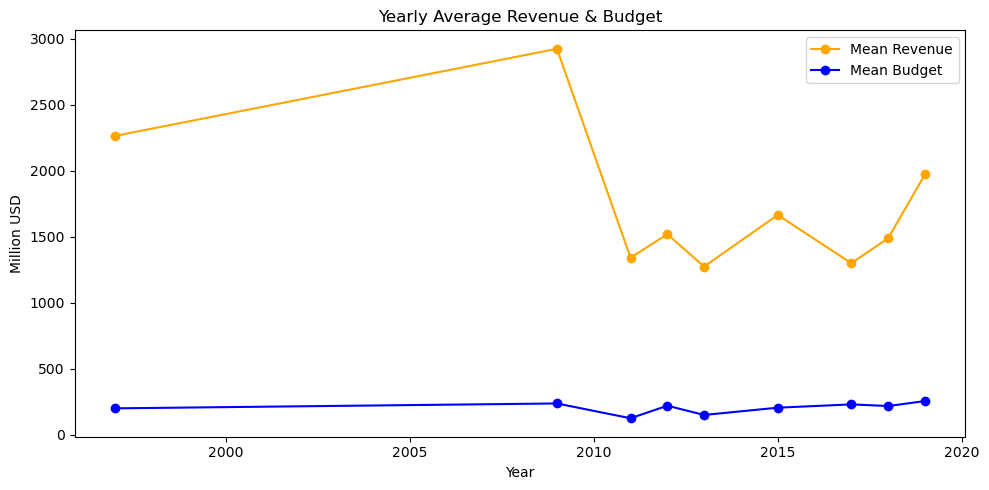

In [36]:
plot_yearly_trends(df)

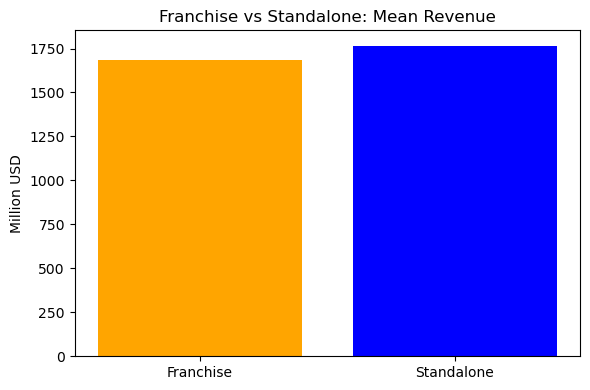

In [37]:
plot_franchise_vs_standalone_revenue(franchise_movies,standalone_movies)